## We test RML18 dataset on model trained on RML22. RML22 modulation types is a subset of RML18. We therefore test on this susbet from RML18.

## Load RML18 and store the subset of modulation types into a pickle file

In [1]:
import h5py
import sys
from scipy import signal
import pickle

L = 128


def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['', 'Ki', 'Mi', 'Gi', 'Ti', 'Pi', 'Ei', 'Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


## RML18 dataset (GOLD_XYZ_OSC.0001_1024.hdf5) can be downloaded from here: https://www.deepsig.ai/datasets
filename = '/home/vesathya/ModulationClassification/IQSamples/RadioML2018Dataset/GOLD_XYZ_OSC.0001_1024.hdf5'
f = h5py.File(filename, 'r')
classes = ['32PSK', '16APSK', '32QAM', 'FM', 'GMSK', '32APSK', 'OQPSK', '8ASK', 'BPSK', '8PSK', 'AM-SSB-SC', 'PAM4',
           '16PSK',
           '64APSK', '128QAM', '128APSK', 'AM-DSB-SC', 'AM-SSB-WC', '64QAM', 'QPSK', '256QAM', 'AM-DSB-WC', 'OOK',
           '16QAM']
modulationTypes = ["BPSK", "QPSK", "8PSK", "16QAM", "64QAM", "PAM4", "GMSK", "OQPSK", "FM", "AM-DSB-SC"]
label_dict = {'16QAM': 0, '64QAM': 1, '8PSK': 2, 'FM': 3, 'BPSK': 4, 'OQPSK': 5, 'AM-DSB-SC': 6, 'GMSK': 7,
              'PAM4': 8, 'QPSK': 9, 'AM-SSB-SC': 10}

modulationTypes_RML22 = ["BPSK", "QPSK", "8PSK", "16QAM", "64QAM", "PAM4", "GFSK", "CPFSK", "BFM", "DSBAM"]

label_dict_RML22 = {'QAM16': 0, 'QAM64': 1, '8PSK': 2, 'WBFM': 3, 'BPSK': 4, 'CPFSK': 5, 'AM-DSB': 6, 'GFSK': 7,
                    'PAM4': 8, 'QPSK': 9}
label_RML18_RML22 = {'16QAM': 'QAM16', '64QAM': 'QAM64', '8PSK': '8PSK', 'FM': 'WBFM', 'BPSK': 'BPSK', \
                     'AM-DSB-SC': 'AM-DSB', 'GMSK': 'GFSK', 'PAM4': 'PAM4', 'QPSK': 'QPSK'}

print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

frame_length = 128
# Get the data
# datalist = list(f[a_group_key])
import numpy as np

data = np.array(f[a_group_key])
oneHotLabel = np.array(f['Y'])
i1, label = np.where(oneHotLabel == 1)
SNR = np.array(f['Z'])
SNR_val_unique = np.unique(SNR)

dataset = {}
dataset_resample = {}
dataset_8sps = {}
downsample_factor = 4
upsample_factor = 1
for modval in label_RML18_RML22.keys():
    print(modval)
    modval_number = classes.index(modval)  # np.where(classes==modval)
    data_temp = data[label == modval_number]
    data_temp_axisshift = np.moveaxis(data_temp, [0, 1, 2], [-3, -1, -2])

    #     data_small = np.append(data_small, data_temp, axis=0)
    #     label_temp = np.ones(data_temp.shape[0], dtype=int) * label_dict[modval]
    #     label_small = np.append(label_small, label_temp, axis=0)
    SNR_temp = SNR[label == modval_number]
    SNR_temp = SNR_temp.reshape((len(SNR_temp),))
    # snr_small = np.append(snr_small, SNR_temp, axis=0)
    for snr2 in SNR_val_unique:
        print(snr2)
        data_temp2 = data_temp[SNR_temp == snr2]
        data_temp7 = np.moveaxis(data_temp2, [0, 1, 2], [-3, -1, -2])
        data_temp6 = np.zeros((data_temp2.shape[0], 2, 256))
        data_temp8 = np.zeros((data_temp2.shape[0], 2, 256))
        # we have two approaches: downsampling by 4 to get dataset with sps = 2 and then normalizing it.
        # Or taking data with sps = 8 and testing it on appropriate model

        ## We resample 1024 complex samples - native sample rate is 8, new sample rate is 2. We thus get 256 samples now. Out of which we take 128 samples.
        for idx3 in np.arange(data_temp7.shape[0]):
            data_temp_resample_axis0 = signal.resample_poly(data_temp7[idx3, 0, :], upsample_factor, downsample_factor)
            data_temp6[idx3, 0, :] = data_temp_resample_axis0
            data_temp_resample_axis1 = signal.resample_poly(data_temp7[idx3, 1, :], upsample_factor, downsample_factor)
            data_temp6[idx3, 1, :] = data_temp_resample_axis1
            data_temp_complex_resample = data_temp6[idx3, 0, :] + 1j * data_temp6[idx3, 1, :]
            data_temp8[idx3, 0, :] = np.real(data_temp_complex_resample / np.sum(np.abs(data_temp_complex_resample)))
            data_temp8[idx3, 1, :] = np.imag(data_temp_complex_resample / np.sum(np.abs(data_temp_complex_resample)))

        dataset_resample[(label_RML18_RML22[modval], snr2)] = data_temp8
        dataset_8sps[(label_RML18_RML22[modval], snr2)] = data_temp_axisshift[:,:,0:frame_length]
dataset = {}
for keyval in dataset_resample.keys():
    dataset[keyval] = dataset_resample[keyval][:, :, 0:frame_length]

with open('RML18DatasetResampledSPS2_ForTestingOnRML22TrainedModel.pickle', 'wb') as handle:
    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('RML18DatasetSPS8_ForTestingOnRML22TrainedModel.pickle', 'wb') as handle:
    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

Keys: <KeysViewHDF5 ['X', 'Y', 'Z']>
16QAM
-20
-18
-16
-14
-12
-10
-8
-6
-4
-2
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
64QAM
-20
-18
-16
-14
-12
-10
-8
-6
-4
-2
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
8PSK
-20
-18
-16
-14
-12
-10
-8
-6
-4
-2
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
FM
-20
-18
-16
-14
-12
-10
-8
-6
-4
-2
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
BPSK
-20
-18
-16
-14
-12
-10
-8
-6
-4
-2
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
AM-DSB-SC
-20
-18
-16
-14
-12
-10
-8
-6
-4
-2
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
GMSK
-20
-18
-16
-14
-12
-10
-8
-6
-4
-2
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
PAM4
-20
-18
-16
-14
-12
-10
-8
-6
-4
-2
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
QPSK
-20
-18
-16
-14
-12
-10
-8
-6
-4
-2
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30


## Test a model trained on RML22, on the RML18 dataset that is decimated from sps=8 to sps=2

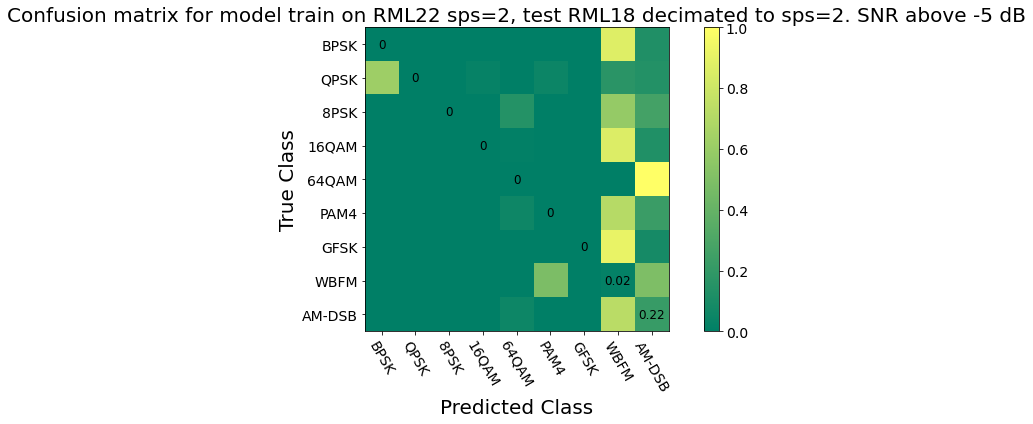

In [4]:

import sys
sys.path.insert(1, '/home/vesathya/ModulationClassification/ModelClassDefinitions/')
sys.path.insert(1, '/home/vesathya/ModulationClassification/Mainfiles_Sep2020/')
sys.path.insert(1, '/home/vesathya/ModulationClassification/Aug2020/Code/JournalPaperSNRPartitioning/CFOSweep/Final/Jan23rd/SingleRun/')

import numpy as np
import pickle
import datetime
import torch.nn as nn
import torch
from TrainHelper import train_model
from sklearn.model_selection import train_test_split
from CNNArchitecture import CNNArchitecture
import os
import matplotlib.pyplot as plt
import logging
from sklearn.metrics import confusion_matrix

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')
    
    
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
##Load dataset

with open('RML18DatasetResampledSPS2_ForTestingOnRML22TrainedModel.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dataset.keys())))), [1, 0])

# modulationTypes = ["BPSK", "QPSK", "8PSK", "16QAM", "64QAM", "PAM4", "GFSK", "BFM", "DSBAM"]

label_dict = {'QAM16': 0, 'QAM64': 1, '8PSK': 2, 'WBFM': 3, 'BPSK': 4, 'CPFSK': 5, 'AM-DSB': 6, 'GFSK': 7,
              'PAM4': 8, 'QPSK': 9}
label_dict_RML22 = {'QAM16': 0, 'QAM64': 1, '8PSK': 2, 'WBFM': 3, 'BPSK': 4, 'CPFSK': 5, 'AM-DSB': 6, 'GFSK': 7,
              'PAM4': 8, 'QPSK': 9}
label_RML18_RML22 = {'16QAM':'QAM16', '64QAM':'QAM64', '8PSK':'8PSK', 'FM':'WBFM', 'BPSK':'BPSK', \
    'AM-DSB-SC':'AM-DSB', 'GMSK':'GFSK','PAM4':'PAM4', 'QPSK':'QPSK'}
DatasetParams = {}
# L = 128
DatasetParams['SNRrange'] = np.sort(snrs)
DatasetParams['Modulationtypes'] = mods
# DatasetParams['NumClasses'] = len(DatasetParams['Modulationtypes'])
DatasetParams['datatype'] = 'LRScheduled_0.001_BS_128XavierAdam_L_128_dataIs_RML2022All.01A_model.pt'
#'LRScheduled_0.001_BS_32XavierAdam_L_128_dataIs_RML2016.10a_dict_SNR20include_3000IFs_model.pt'
#'LRScheduled_0.001_BS_128XavierAdam_L_128_dataIs_RML2022All.01A_model.pt'

DatasetParams['frameLength'] = 128
TestParams = {}
TestParams['validation_size'] = 0.8
TestParams['test_BS'] = 128
TestParams['computing_device'] = torch.device("cuda")
modulation_reordered = ['BPSK', 'QPSK', '8PSK', '16QAM', '64QAM', 'PAM4', 'GFSK', 'WBFM', 'AM-DSB']
DatasetParams['NumClasses'] = len(mods) + 1


model_location = '/home/vesathya/ModulationClassification/Aug2020/Code/JournalPaperSNRPartitioning/CFOSweep/Final/Jan23rd/models/Jan24th/'
# FinalJan23rdmodelsJan24th

modelfile = model_location + DatasetParams['datatype']
accuracy = {}
# dataset = {}

def calculate_accuracy(model, data, label, batch_size, computing_device, CM_flag):
    model.eval()
    with torch.no_grad():
        n_samples = data.shape[0]
        n_minibatch = int((n_samples + batch_size - 1) / batch_size)
        accuracy = 0
        I = np.arange(n_samples)
        CM_prediction = []
        for i in range(n_minibatch):
            idx = I[batch_size * i:min(batch_size * (i + 1), n_samples)]
            dt = data[idx].to(computing_device)
            lbl = label[idx].numpy()
            output = model(dt)
            output = output.cpu().numpy()
            output = np.argmax(output, axis=1)
            CM_prediction.extend(list(output))
            accuracy += np.sum(output == lbl)
        if CM_flag:
            return accuracy / n_samples, CM_prediction
        else:
            return accuracy / n_samples
 

for mod in DatasetParams['Modulationtypes']:
    for snr in DatasetParams['SNRrange']:

        # Load pre-trained model
        modelclass = CNNArchitecture
        if 'model' in globals():
            del model  # deleting it so that pre-loaded model in previous loop iteration doesnt not mess up this one.
        model = modelclass(DatasetParams['NumClasses'])
        model.load_state_dict(torch.load(modelfile))
        model = model.to(TestParams['computing_device'])
        data = dataset[(mod, snr)]   #dataset[(mod, snr)][0:DatasetParams['NumFrames']]
        
        label = label_dict[mod]*np.ones((data.shape[0],))
        x_train, x_test, y_train, y_test = train_test_split(data, label,
                                                            test_size=TestParams['validation_size'],
                                                            random_state=1)
#         print(x_test.shape)
        test_data = torch.tensor(x_test).float()
        test_label = torch.tensor(y_test).float()
        accuracy[(mod,snr)] = calculate_accuracy(model, test_data, test_label,
                                                                            TestParams['test_BS'],
                                                                            TestParams['computing_device'],False)

lowSNR = -4
highSNR = np.sort(snrs)[-1] + 1
snrrange_confusionmatrix = range(lowSNR,highSNR,2)
X = []
lbl = []
for mod in mods:
        for snr in snrrange_confusionmatrix:
#                 X.append(dataset[(mod, snr)][0:DatasetParams['NumFrames']])
                X.append(dataset[(mod, snr)])
                for i in range(dataset[(mod, snr)].shape[0]):  lbl.append((mod, snr))
# del dataset
X = np.vstack(X)
label_val = list(map(lambda x: lbl[x][0], range(len(lbl))))
label = list(map(lambda x: label_dict[x], label_val))
label = np.array(label)
dataset_traintest = X[:, :, 0:DatasetParams['frameLength']]
del X
    
x_train, x_test, y_train, y_test = train_test_split(dataset_traintest, label, test_size=\
                        TestParams['validation_size'],random_state=1)
test_data = torch.tensor(x_test).float()
test_label = torch.tensor(y_test).float()
acc_dummy, y_pred = calculate_accuracy(model, test_data, test_label, TestParams['test_BS'],\
                        TestParams['computing_device'],True)
# Order of modulations are BPSK, QPSK, 8PSK, 16QAM, 64QAM, PAM4, CPFSK, GFSK, QBFM, AM-DSB
        # We group similar modulation types together in the confusion matrix plots. 
        # Phase senstive ones followed by other digital and then analog modulation types.
label_reordered = [4, 9, 2, 0, 1, 8, 7, 3, 6]#[4, 9, 2, 0, 1, 8, 5, 7, 3, 6]
confusion_mat = confusion_matrix(y_test, y_pred, label_reordered)
confusion_mat = confusion_mat.astype(float)        

accvsSNR = {}
plt.figure(1,figsize=(10,6))
snridx = 0
accvsSNR = np.zeros((len(DatasetParams['SNRrange']),))
for snr in DatasetParams['SNRrange']:
    for mod in DatasetParams['Modulationtypes']:
        accvsSNR[snridx] = accvsSNR[snridx] + accuracy[mod,snr]
    accvsSNR[snridx] = accvsSNR[snridx]/len(DatasetParams['Modulationtypes'])
    snridx = snridx+1
markerval = 'o'
# plt.plot(DatasetParams['SNRrange'],accvsSNR,markerval,markersize=10)

# plt.tick_params(top=False,bottom=True,left=True,right=False,labelleft=True,labelbottom=True,length=8,width=3,\
#                 direction='out')
# # plt.legend(legend_text,fontsize=36)
# plt.title("Test accuracy for model train on RML22, test RML18",fontsize=20)
# plt.xlabel("SNR in dB",fontsize=20)
# plt.ylabel("Accuracy",fontsize=20)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.tight_layout()
# plt.show()

confusionmat_norm = np.zeros(confusion_mat.shape)
for row_idx in np.arange(confusion_mat.shape[0]):
    sum = np.sum(confusion_mat[row_idx])
    for col_idx in np.arange(confusion_mat.shape[1]):
        confusionmat_norm[row_idx][col_idx] = confusion_mat[row_idx][col_idx]/sum
plt.figure(1,figsize=(10,6))

im = plt.imshow(confusionmat_norm, cmap='summer', interpolation='nearest',vmin=0, vmax=1)

width, height = confusionmat_norm.shape
for x in range(width):
    for y in range(height):
        if x==y:

            confusionmat_norm_val_2decimalplaces = "{:0.2f}".format(confusionmat_norm[x][y])
            if confusionmat_norm_val_2decimalplaces == "1.00":
                confusionmat_norm_val_2decimalplaces = "1.0"
            if confusionmat_norm_val_2decimalplaces == "0.00":
                confusionmat_norm_val_2decimalplaces = "0"
            plt.annotate(str(confusionmat_norm_val_2decimalplaces), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',fontsize=12)

plt.xticks(np.arange(len(mods)), modulation_reordered, rotation=300,fontsize=14)
plt.yticks([], [])
plt.title("Confusion matrix for model train on RML22 sps=2, test RML18 decimated to sps=2. SNR above -5 dB",fontsize=20)
plt.xlabel('Predicted Class',fontsize=20)
cbar = plt.colorbar(im)
tick_font_size = 14
cbar.ax.tick_params(labelsize=tick_font_size)
plt.yticks(np.arange(len(mods)), modulation_reordered, rotation=0,fontsize=14)
plt.ylabel('True Class',fontsize=20)
plt.tight_layout()
plt.show()



## Test a model trained on RML22 sps=8, on the RML18 dataset

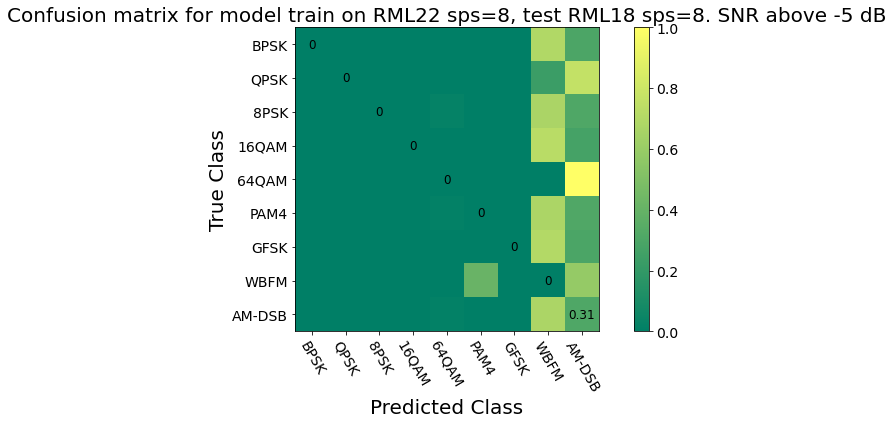

In [5]:

import sys
sys.path.insert(1, '/home/vesathya/ModulationClassification/ModelClassDefinitions/')
sys.path.insert(1, '/home/vesathya/ModulationClassification/Mainfiles_Sep2020/')
sys.path.insert(1, '/home/vesathya/ModulationClassification/Aug2020/Code/JournalPaperSNRPartitioning/CFOSweep/Final/Jan23rd/SingleRun/')

import numpy as np
import pickle
import datetime
import torch.nn as nn
import torch
from TrainHelper import train_model
from sklearn.model_selection import train_test_split
from CNNArchitecture import CNNArchitecture
import os
import matplotlib.pyplot as plt
import logging
from sklearn.metrics import confusion_matrix

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')
    
    
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
##Load dataset

with open('RML18DatasetSPS8_ForTestingOnRML22TrainedModel.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dataset.keys())))), [1, 0])

# modulationTypes = ["BPSK", "QPSK", "8PSK", "16QAM", "64QAM", "PAM4", "GFSK", "BFM", "DSBAM"]

label_dict = {'QAM16': 0, 'QAM64': 1, '8PSK': 2, 'WBFM': 3, 'BPSK': 4, 'CPFSK': 5, 'AM-DSB': 6, 'GFSK': 7,
              'PAM4': 8, 'QPSK': 9}
label_dict_RML22 = {'QAM16': 0, 'QAM64': 1, '8PSK': 2, 'WBFM': 3, 'BPSK': 4, 'CPFSK': 5, 'AM-DSB': 6, 'GFSK': 7,
              'PAM4': 8, 'QPSK': 9}
label_RML18_RML22 = {'16QAM':'QAM16', '64QAM':'QAM64', '8PSK':'8PSK', 'FM':'WBFM', 'BPSK':'BPSK', \
    'AM-DSB-SC':'AM-DSB', 'GMSK':'GFSK','PAM4':'PAM4', 'QPSK':'QPSK'}
DatasetParams = {}
# L = 128
DatasetParams['SNRrange'] = np.sort(snrs)
DatasetParams['Modulationtypes'] = mods
# DatasetParams['NumClasses'] = len(DatasetParams['Modulationtypes'])
DatasetParams['datatype'] = 'LRScheduled_0.001_BS_128XavierAdam_L_128_dataIs_RML22_8samplespersymbol_All.01A_model.pt'

#'LRScheduled_0.001_BS_128XavierAdam_L_128_dataIs_RML2022All.01A_model.pt'
#'LRScheduled_0.001_BS_32XavierAdam_L_128_dataIs_RML2016.10a_dict_SNR20include_3000IFs_model.pt'
#'LRScheduled_0.001_BS_128XavierAdam_L_128_dataIs_RML2022All.01A_model.pt'

DatasetParams['frameLength'] = 128
TestParams = {}
TestParams['validation_size'] = 0.8
TestParams['test_BS'] = 128
TestParams['computing_device'] = torch.device("cuda")
modulation_reordered = ['BPSK', 'QPSK', '8PSK', '16QAM', '64QAM', 'PAM4', 'GFSK', 'WBFM', 'AM-DSB']
DatasetParams['NumClasses'] = len(mods) + 1


model_location = '/home/vesathya/ModulationClassification/Aug2020/Code/JournalPaperSNRPartitioning/CFOSweep/Final/Jan23rd/models/Jan24th/'
# FinalJan23rdmodelsJan24th

modelfile = model_location + DatasetParams['datatype']
accuracy = {}
# dataset = {}

def calculate_accuracy(model, data, label, batch_size, computing_device, CM_flag):
    model.eval()
    with torch.no_grad():
        n_samples = data.shape[0]
        n_minibatch = int((n_samples + batch_size - 1) / batch_size)
        accuracy = 0
        I = np.arange(n_samples)
        CM_prediction = []
        for i in range(n_minibatch):
            idx = I[batch_size * i:min(batch_size * (i + 1), n_samples)]
            dt = data[idx].to(computing_device)
            lbl = label[idx].numpy()
            output = model(dt)
            output = output.cpu().numpy()
            output = np.argmax(output, axis=1)
            CM_prediction.extend(list(output))
            accuracy += np.sum(output == lbl)
        if CM_flag:
            return accuracy / n_samples, CM_prediction
        else:
            return accuracy / n_samples
 

for mod in DatasetParams['Modulationtypes']:
    for snr in DatasetParams['SNRrange']:

        # Load pre-trained model
        modelclass = CNNArchitecture
        if 'model' in globals():
            del model  # deleting it so that pre-loaded model in previous loop iteration doesnt not mess up this one.
        model = modelclass(DatasetParams['NumClasses'])
        model.load_state_dict(torch.load(modelfile))
        model = model.to(TestParams['computing_device'])
        data = dataset[(mod, snr)]   #dataset[(mod, snr)][0:DatasetParams['NumFrames']]
        
        label = label_dict[mod]*np.ones((data.shape[0],))
        x_train, x_test, y_train, y_test = train_test_split(data, label,
                                                            test_size=TestParams['validation_size'],
                                                            random_state=1)
#         print(x_test.shape)
        test_data = torch.tensor(x_test).float()
        test_label = torch.tensor(y_test).float()
        accuracy[(mod,snr)] = calculate_accuracy(model, test_data, test_label,
                                                                            TestParams['test_BS'],
                                                                            TestParams['computing_device'],False)

lowSNR = -4
highSNR = np.sort(snrs)[-1] + 1
snrrange_confusionmatrix = range(lowSNR,highSNR,2)
X = []
lbl = []
for mod in mods:
        for snr in snrrange_confusionmatrix:
#                 X.append(dataset[(mod, snr)][0:DatasetParams['NumFrames']])
                X.append(dataset[(mod, snr)])
                for i in range(dataset[(mod, snr)].shape[0]):  lbl.append((mod, snr))
# del dataset
X = np.vstack(X)
label_val = list(map(lambda x: lbl[x][0], range(len(lbl))))
label = list(map(lambda x: label_dict[x], label_val))
label = np.array(label)
dataset_traintest = X[:, :, 0:DatasetParams['frameLength']]
del X
    
x_train, x_test, y_train, y_test = train_test_split(dataset_traintest, label, test_size=\
                        TestParams['validation_size'],random_state=1)
test_data = torch.tensor(x_test).float()
test_label = torch.tensor(y_test).float()
acc_dummy, y_pred = calculate_accuracy(model, test_data, test_label, TestParams['test_BS'],\
                        TestParams['computing_device'],True)
# Order of modulations are BPSK, QPSK, 8PSK, 16QAM, 64QAM, PAM4, CPFSK, GFSK, QBFM, AM-DSB
        # We group similar modulation types together in the confusion matrix plots. 
        # Phase senstive ones followed by other digital and then analog modulation types.
label_reordered = [4, 9, 2, 0, 1, 8, 7, 3, 6]#[4, 9, 2, 0, 1, 8, 5, 7, 3, 6]
confusion_mat = confusion_matrix(y_test, y_pred, label_reordered)
confusion_mat = confusion_mat.astype(float)        

accvsSNR = {}
plt.figure(1,figsize=(10,6))
snridx = 0
accvsSNR = np.zeros((len(DatasetParams['SNRrange']),))
for snr in DatasetParams['SNRrange']:
    for mod in DatasetParams['Modulationtypes']:
        accvsSNR[snridx] = accvsSNR[snridx] + accuracy[mod,snr]
    accvsSNR[snridx] = accvsSNR[snridx]/len(DatasetParams['Modulationtypes'])
    snridx = snridx+1
markerval = 'o'
# plt.plot(DatasetParams['SNRrange'],accvsSNR,markerval,markersize=10)

# plt.tick_params(top=False,bottom=True,left=True,right=False,labelleft=True,labelbottom=True,length=8,width=3,\
#                 direction='out')
# # plt.legend(legend_text,fontsize=36)
# plt.title("Test accuracy for model train on RML22, test RML18",fontsize=20)
# plt.xlabel("SNR in dB",fontsize=20)
# plt.ylabel("Accuracy",fontsize=20)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.tight_layout()
# plt.show()

confusionmat_norm = np.zeros(confusion_mat.shape)
for row_idx in np.arange(confusion_mat.shape[0]):
    sum = np.sum(confusion_mat[row_idx])
    for col_idx in np.arange(confusion_mat.shape[1]):
        confusionmat_norm[row_idx][col_idx] = confusion_mat[row_idx][col_idx]/sum
plt.figure(1,figsize=(10,6))

im = plt.imshow(confusionmat_norm, cmap='summer', interpolation='nearest',vmin=0, vmax=1)

width, height = confusionmat_norm.shape
for x in range(width):
    for y in range(height):
        if x==y:

            confusionmat_norm_val_2decimalplaces = "{:0.2f}".format(confusionmat_norm[x][y])
            if confusionmat_norm_val_2decimalplaces == "1.00":
                confusionmat_norm_val_2decimalplaces = "1.0"
            if confusionmat_norm_val_2decimalplaces == "0.00":
                confusionmat_norm_val_2decimalplaces = "0"
            plt.annotate(str(confusionmat_norm_val_2decimalplaces), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',fontsize=12)

plt.xticks(np.arange(len(mods)), modulation_reordered, rotation=300,fontsize=14)
plt.yticks([], [])
plt.title("Confusion matrix for model train on RML22 sps=8, test RML18 sps=8. SNR above -5 dB",fontsize=20)
plt.xlabel('Predicted Class',fontsize=20)
cbar = plt.colorbar(im)
tick_font_size = 14
cbar.ax.tick_params(labelsize=tick_font_size)
plt.yticks(np.arange(len(mods)), modulation_reordered, rotation=0,fontsize=14)
plt.ylabel('True Class',fontsize=20)
plt.tight_layout()
plt.show()



## Test a model trained on RML16 sps=8, on the RML18 dataset

In [ ]:

import sys
sys.path.insert(1, '/home/vesathya/ModulationClassification/ModelClassDefinitions/')
sys.path.insert(1, '/home/vesathya/ModulationClassification/Mainfiles_Sep2020/')
sys.path.insert(1, '/home/vesathya/ModulationClassification/Aug2020/Code/JournalPaperSNRPartitioning/CFOSweep/Final/Jan23rd/SingleRun/')

import numpy as np
import pickle
import datetime
import torch.nn as nn
import torch
from TrainHelper import train_model
from sklearn.model_selection import train_test_split
from CNNArchitecture import CNNArchitecture
import os
import matplotlib.pyplot as plt
import logging
from sklearn.metrics import confusion_matrix

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')
    
    
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
##Load dataset

with open('RML18DatasetSPS8_ForTestingOnRML22TrainedModel.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dataset.keys())))), [1, 0])

# modulationTypes = ["BPSK", "QPSK", "8PSK", "16QAM", "64QAM", "PAM4", "GFSK", "BFM", "DSBAM"]

label_dict = {'QAM16': 0, 'QAM64': 1, '8PSK': 2, 'WBFM': 3, 'BPSK': 4, 'CPFSK': 5, 'AM-DSB': 6, 'GFSK': 7,
              'PAM4': 8, 'QPSK': 9}
label_dict_RML22 = {'QAM16': 0, 'QAM64': 1, '8PSK': 2, 'WBFM': 3, 'BPSK': 4, 'CPFSK': 5, 'AM-DSB': 6, 'GFSK': 7,
              'PAM4': 8, 'QPSK': 9}
label_RML18_RML22 = {'16QAM':'QAM16', '64QAM':'QAM64', '8PSK':'8PSK', 'FM':'WBFM', 'BPSK':'BPSK', \
    'AM-DSB-SC':'AM-DSB', 'GMSK':'GFSK','PAM4':'PAM4', 'QPSK':'QPSK'}
DatasetParams = {}
# L = 128
DatasetParams['SNRrange'] = np.sort(snrs)
DatasetParams['Modulationtypes'] = mods
# DatasetParams['NumClasses'] = len(DatasetParams['Modulationtypes'])
DatasetParams['datatype'] = 'LRScheduled_0.001_BS_32XavierAdam_L_128_dataIs_RML2016.10a_dict_SNR20include_3000IFs_model.pt'

#'LRScheduled_0.001_BS_128XavierAdam_L_128_dataIs_RML22_8samplespersymbol_All.01A_model.pt'

#'LRScheduled_0.001_BS_128XavierAdam_L_128_dataIs_RML2022All.01A_model.pt'
#'LRScheduled_0.001_BS_32XavierAdam_L_128_dataIs_RML2016.10a_dict_SNR20include_3000IFs_model.pt'
#'LRScheduled_0.001_BS_128XavierAdam_L_128_dataIs_RML2022All.01A_model.pt'

DatasetParams['frameLength'] = 128
TestParams = {}
TestParams['validation_size'] = 0.8
TestParams['test_BS'] = 128
TestParams['computing_device'] = torch.device("cuda")
modulation_reordered = ['BPSK', 'QPSK', '8PSK', '16QAM', '64QAM', 'PAM4', 'GFSK', 'WBFM', 'AM-DSB']
DatasetParams['NumClasses'] = len(mods) + 1


model_location = '/home/vesathya/ModulationClassification/Aug2020/Code/JournalPaperSNRPartitioning/CFOSweep/Final/Jan23rd/models/Jan24th/'
# FinalJan23rdmodelsJan24th

modelfile = model_location + DatasetParams['datatype']
accuracy = {}
# dataset = {}

def calculate_accuracy(model, data, label, batch_size, computing_device, CM_flag):
    model.eval()
    with torch.no_grad():
        n_samples = data.shape[0]
        n_minibatch = int((n_samples + batch_size - 1) / batch_size)
        accuracy = 0
        I = np.arange(n_samples)
        CM_prediction = []
        for i in range(n_minibatch):
            idx = I[batch_size * i:min(batch_size * (i + 1), n_samples)]
            dt = data[idx].to(computing_device)
            lbl = label[idx].numpy()
            output = model(dt)
            output = output.cpu().numpy()
            output = np.argmax(output, axis=1)
            CM_prediction.extend(list(output))
            accuracy += np.sum(output == lbl)
        if CM_flag:
            return accuracy / n_samples, CM_prediction
        else:
            return accuracy / n_samples
 

for mod in DatasetParams['Modulationtypes']:
    for snr in DatasetParams['SNRrange']:

        # Load pre-trained model
        modelclass = CNNArchitecture
        if 'model' in globals():
            del model  # deleting it so that pre-loaded model in previous loop iteration doesnt not mess up this one.
        model = modelclass(DatasetParams['NumClasses'])
        model.load_state_dict(torch.load(modelfile))
        model = model.to(TestParams['computing_device'])
        data = dataset[(mod, snr)]   #dataset[(mod, snr)][0:DatasetParams['NumFrames']]
        
        label = label_dict[mod]*np.ones((data.shape[0],))
        x_train, x_test, y_train, y_test = train_test_split(data, label,
                                                            test_size=TestParams['validation_size'],
                                                            random_state=1)
#         print(x_test.shape)
        test_data = torch.tensor(x_test).float()
        test_label = torch.tensor(y_test).float()
        accuracy[(mod,snr)] = calculate_accuracy(model, test_data, test_label,
                                                                            TestParams['test_BS'],
                                                                            TestParams['computing_device'],False)

lowSNR = -4
highSNR = np.sort(snrs)[-1] + 1
snrrange_confusionmatrix = range(lowSNR,highSNR,2)
X = []
lbl = []
for mod in mods:
        for snr in snrrange_confusionmatrix:
#                 X.append(dataset[(mod, snr)][0:DatasetParams['NumFrames']])
                X.append(dataset[(mod, snr)])
                for i in range(dataset[(mod, snr)].shape[0]):  lbl.append((mod, snr))
# del dataset
X = np.vstack(X)
label_val = list(map(lambda x: lbl[x][0], range(len(lbl))))
label = list(map(lambda x: label_dict[x], label_val))
label = np.array(label)
dataset_traintest = X[:, :, 0:DatasetParams['frameLength']]
del X
    
x_train, x_test, y_train, y_test = train_test_split(dataset_traintest, label, test_size=\
                        TestParams['validation_size'],random_state=1)
test_data = torch.tensor(x_test).float()
test_label = torch.tensor(y_test).float()
acc_dummy, y_pred = calculate_accuracy(model, test_data, test_label, TestParams['test_BS'],\
                        TestParams['computing_device'],True)
# Order of modulations are BPSK, QPSK, 8PSK, 16QAM, 64QAM, PAM4, CPFSK, GFSK, QBFM, AM-DSB
        # We group similar modulation types together in the confusion matrix plots. 
        # Phase senstive ones followed by other digital and then analog modulation types.
label_reordered = [4, 9, 2, 0, 1, 8, 7, 3, 6]#[4, 9, 2, 0, 1, 8, 5, 7, 3, 6]
confusion_mat = confusion_matrix(y_test, y_pred, label_reordered)
confusion_mat = confusion_mat.astype(float)        

accvsSNR = {}
plt.figure(1,figsize=(10,6))
snridx = 0
accvsSNR = np.zeros((len(DatasetParams['SNRrange']),))
for snr in DatasetParams['SNRrange']:
    for mod in DatasetParams['Modulationtypes']:
        accvsSNR[snridx] = accvsSNR[snridx] + accuracy[mod,snr]
    accvsSNR[snridx] = accvsSNR[snridx]/len(DatasetParams['Modulationtypes'])
    snridx = snridx+1
markerval = 'o'
# plt.plot(DatasetParams['SNRrange'],accvsSNR,markerval,markersize=10)

# plt.tick_params(top=False,bottom=True,left=True,right=False,labelleft=True,labelbottom=True,length=8,width=3,\
#                 direction='out')
# # plt.legend(legend_text,fontsize=36)
# plt.title("Test accuracy for model train on RML22, test RML18",fontsize=20)
# plt.xlabel("SNR in dB",fontsize=20)
# plt.ylabel("Accuracy",fontsize=20)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.tight_layout()
# plt.show()

confusionmat_norm = np.zeros(confusion_mat.shape)
for row_idx in np.arange(confusion_mat.shape[0]):
    sum = np.sum(confusion_mat[row_idx])
    for col_idx in np.arange(confusion_mat.shape[1]):
        confusionmat_norm[row_idx][col_idx] = confusion_mat[row_idx][col_idx]/sum
plt.figure(1,figsize=(10,6))

im = plt.imshow(confusionmat_norm, cmap='summer', interpolation='nearest',vmin=0, vmax=1)

width, height = confusionmat_norm.shape
for x in range(width):
    for y in range(height):
        if x==y:

            confusionmat_norm_val_2decimalplaces = "{:0.2f}".format(confusionmat_norm[x][y])
            if confusionmat_norm_val_2decimalplaces == "1.00":
                confusionmat_norm_val_2decimalplaces = "1.0"
            if confusionmat_norm_val_2decimalplaces == "0.00":
                confusionmat_norm_val_2decimalplaces = "0"
            plt.annotate(str(confusionmat_norm_val_2decimalplaces), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',fontsize=12)

plt.xticks(np.arange(len(mods)), modulation_reordered, rotation=300,fontsize=14)
plt.yticks([], [])
plt.title("Confusion matrix for model train on RML16 sps=8, test RML18 sps=8. SNR above -5 dB",fontsize=20)
plt.xlabel('Predicted Class',fontsize=20)
cbar = plt.colorbar(im)
tick_font_size = 14
cbar.ax.tick_params(labelsize=tick_font_size)
plt.yticks(np.arange(len(mods)), modulation_reordered, rotation=0,fontsize=14)
plt.ylabel('True Class',fontsize=20)
plt.tight_layout()
plt.show()

